## Collateral in MIM Cauldrons

Load some useful modules and scripts

In [ ]:
from web3 import Web3
import pandas as pd
import os, sys, json
from matplotlib import pyplot as plt
import numpy as np
import re
import requests
from dotenv import load_dotenv
load_dotenv('../.env')

# Scripts
scripts_module_path = os.path.abspath(os.path.join(os.getcwd(),'..', 'scripts'))
if scripts_module_path not in sys.path:
    sys.path.append(scripts_module_path)
from acquisition import Acquisition as Akw
w3 = Web3(Web3.HTTPProvider(os.getenv("ALECHEMY_MAINNET_ENDPOINT")))
# w3 = Web3(Web3.IPCProvider('/home/leonhard/.ethereum/geth.ipc'))
print("JSON RPC for Alchemy is connected: ", w3.isConnected())

### Load Cauldron ABI

In [ ]:
MIM_UST_Cauldron_address = '0x59E9082E068Ddb27FC5eF1690F9a9f22B32e573f'
MIM_USDC_UniPool_contract = "CauldronWethV2"
filepath = f'../data/contracts/{MIM_USDC_UniPool_contract}.json'
with open(filepath, 'r') as fl:
    interace = json.load(fl)
    ABI = json.dumps(interace["interface"])
mim_ust_cauldron_contract = w3.eth.contract(address=MIM_UST_Cauldron_address, abi=ABI)
# contr_mim = mim_usdc_pool_contract.caller()

In [ ]:
randomBlock = 10939454
myfilter = mim_ust_cauldron_contract.events.LogAddCollateral.createFilter(fromBlock=randomBlock, toBlock='latest')
events_collateral_added = myfilter.get_all_entries()

In [ ]:
address = MIM_UST_Cauldron_address
another_mim_cauldron_contract = w3.eth.contract(address=address, abi=ABI)

In [ ]:
randomBlock = 14070573
address = MIM_UST_Cauldron_address
another_mim_cauldron_contract = w3.eth.contract(address=address, abi=ABI)
myfilter = another_mim_cauldron_contract.events.LogAddCollateral.createFilter(fromBlock=randomBlock, toBlock='latest')
events_collateral_added = myfilter.get_all_entries()

### Fantom Exposure

In [ ]:
http_rpc_fantom = 'https://rpc.ftm.tools/'
w3_rpc = Web3(Web3.HTTPProvider(http_rpc_fantom))
w3_rpc.isConnected()

In [ ]:
AbracadabraWFTM_contract = "AbracadabraWFTM1"
filepath = f'../data/contracts/{AbracadabraWFTM_contract}.json'
with open(filepath, 'r') as fl:
    interace = json.load(fl)
    ABI = json.dumps(interace["interface"])
    AbracadabraWFTM_address = list(interace["addresses"].values())[0]
abracadabraWFTM_contract = w3_rpc.eth.contract(address=AbracadabraWFTM_address, abi=ABI)
# contr_mim = mim_usdc_pool_contract.caller()

In [ ]:
w3_rpc.eth.get_block('latest').number

In [ ]:
[e["name"] for e in abracadabraWFTM_contract.events._events]

In [ ]:
# MIMfilter = abracadabraWFTM_contract.events.LogAddCollateral.createFilter(fromBlock='earliest', toBlock='latest')

In [ ]:
# randomBlock = 0
# myfilter = abracadabraWFTM_contract.events.LogAddCollateral.createFilter(fromBlock=randomBlock, toBlock='latest')
# events_collateral_added_fantom = myfilter.get_all_entries()

In [ ]:
# result = Akw.requestInterface(address='0xd96f48665a1410c0cd669a88898eca36b9fc2cce')

In [ ]:
# bentoBox1 = '0xd96f48665a1410c0cd669a88898eca36b9fc2cce'
# bentoBox2 = '0xf5bce5077908a1b7370b9ae04adc565ebd643966'

### Get all Markets

In [ ]:
scrape = "get this from https://docs.abracadabra.money/our-ecosystem/our-contracts"

import re
address_regex = re.compile('[A-Za-z0-9\(\)\s\%\.\/]+:\s0x')
markets = dict()
basename = ''
name = ''
flag = False
for line in scrape.split('\n'):
    if address_regex.match(line):
        if name not in markets:
            markets[name] = list()
        market = line.replace('\n','').split(': ')
        info = dict(coin=market[0], address=market[1])
        markets[name].append(info)
        flag = True
    else:
        if flag:
            name = basename
        name = line + ' ' + name 
        flag = False

In [ ]:
all_markets = json.load(open('../data/abracadabra/markets.json', 'r'))

In [ ]:
## example: Fantom market
randomBlock = 14070573
address = '0x05500e2Ee779329698DF35760bEdcAAC046e7C27'
ftm_mim_cauldron_contract = w3.eth.contract(address=address, abi=ABI)
ftm_mim_add_collateral_test = ftm_mim_cauldron_contract.events.LogAddCollateral.createFilter(fromBlock='earliest', toBlock='latest')
ftm_mim_add_collateral_test_events = ftm_mim_add_collateral_test.get_all_entries()

In [ ]:
ftm_mim_add_collateral_test = ftm_mim_cauldron_contract.events.LogBorrow.createFilter(fromBlock=randomBlock, toBlock='latest')
ftm_mim_add_collateral_test_events = ftm_mim_add_collateral_test.get_all_entries()

In [ ]:
inputs = {e["name"]:[i["name"] for i in e["inputs"]] for e in ftm_mim_cauldron_contract.events._events} 

In [ ]:
all_events_on_markets_df = pd.DataFrame()
deprecated_on_mainnet = False
for i, (network, markets) in enumerate(all_markets.items()):
    if i>2:
        break
    if i==1:
        deprecated_on_mainnet = True
    print('network: ', network)
    for market in markets:
        print(market)
        address = w3.toChecksumAddress(market["address"].replace(' ',''))
        cauldron_contract = w3.eth.contract(address=address, abi=ABI)
        cauldron_caller = cauldron_contract.caller()
        token_address = cauldron_caller.collateral()
        ## all events
        # LogAddCollateral
        print('LogAddCollateral')
        evts = cauldron_contract.events.LogAddCollateral.createFilter(fromBlock='earliest', toBlock='latest').get_all_entries()
        temp_df = pd.DataFrame(data={inpt: [e["args"][inpt] for e in evts] for inpt in inputs["LogAddCollateral"]})
        temp_df["token"] = market["coin"]
        temp_df["event"] = "LogAddCollateral"
        temp_df["cauldronAddress"] = address
        temp_df["tokenAddress"] = token_address
        temp_df["deprecatedMarket"] = deprecated_on_mainnet
        temp_df["blockNumber"] = np.array([e["blockNumber"] for e in evts], dtype=int)
        try:
            all_events_on_markets_df = all_events_on_markets_df.merge(temp_df, how="outer").copy()
        except:
            all_events_on_markets_df = all_events_on_markets_df.append(temp_df, ignore_index=True).copy()
        del temp_df
        # LogBorrow
        print('LogBorrow')
        evts = cauldron_contract.events.LogBorrow.createFilter(fromBlock='earliest', toBlock='latest').get_all_entries()
        temp_df = pd.DataFrame(data={inpt: [e["args"][inpt] for e in evts] for inpt in inputs["LogBorrow"]})
        temp_df["token"] = market["coin"]
        temp_df["event"] = "LogBorrow"
        temp_df["cauldronAddress"] = address
        temp_df["tokenAddress"] = token_address
        temp_df["deprecatedMarket"] = deprecated_on_mainnet
        temp_df["blockNumber"] = np.array([e["blockNumber"] for e in evts], dtype=int)
        try:
            all_events_on_markets_df = all_events_on_markets_df.merge(temp_df, how="outer").copy()
        except:
            all_events_on_markets_df = all_events_on_markets_df.append(temp_df, ignore_index=True).copy()
        del temp_df
        # LogBorrow
        print('LogRemoveCollateral')
        evts = cauldron_contract.events.LogRemoveCollateral.createFilter(fromBlock='earliest', toBlock='latest').get_all_entries()
        temp_df = pd.DataFrame(data={inpt: [e["args"][inpt] for e in evts] for inpt in inputs["LogRemoveCollateral"]})
        temp_df["token"] = market["coin"]
        temp_df["event"] = "LogRemoveCollateral"
        temp_df["cauldronAddress"] = address
        temp_df["tokenAddress"] = token_address
        temp_df["deprecatedMarket"] = deprecated_on_mainnet
        temp_df["blockNumber"] = np.array([e["blockNumber"] for e in evts], dtype=int)
        try:
            all_events_on_markets_df = all_events_on_markets_df.merge(temp_df, how="outer").copy()
        except:
            all_events_on_markets_df = all_events_on_markets_df.append(temp_df, ignore_index=True).copy()
        del temp_df
        # LogBorrow
        print('LogRepay')
        evts = cauldron_contract.events.LogRepay.createFilter(fromBlock='earliest', toBlock='latest').get_all_entries()
        temp_df = pd.DataFrame(data={inpt: [e["args"][inpt] for e in evts] for inpt in inputs["LogRepay"]})
        temp_df["token"] = market["coin"]
        temp_df["event"] = "LogRepay"
        temp_df["cauldronAddress"] = address
        temp_df["tokenAddress"] = token_address
        temp_df["deprecatedMarket"] = deprecated_on_mainnet
        temp_df["blockNumber"] = np.array([e["blockNumber"] for e in evts], dtype=int)
        try:
            all_events_on_markets_df = all_events_on_markets_df.merge(temp_df, how="outer").copy()
        except:
            all_events_on_markets_df = all_events_on_markets_df.append(temp_df, ignore_index=True).copy()
        del temp_df
        # LogBorrow
        print('LogWithdrawFees')
        evts = cauldron_contract.events.LogWithdrawFees.createFilter(fromBlock='earliest', toBlock='latest').get_all_entries()
        temp_df = pd.DataFrame(data={inpt: [e["args"][inpt] for e in evts] for inpt in inputs["LogWithdrawFees"]})
        temp_df["token"] = market["coin"]
        temp_df["event"] = "LogWithdrawFees"
        temp_df["cauldronAddress"] = address
        temp_df["tokenAddress"] = token_address
        temp_df["deprecatedMarket"] = deprecated_on_mainnet
        temp_df["blockNumber"] = np.array([e["blockNumber"] for e in evts], dtype=int)
        try:
            all_events_on_markets_df = all_events_on_markets_df.merge(temp_df, how="outer").copy()
        except:
            all_events_on_markets_df = all_events_on_markets_df.append(temp_df, ignore_index=True).copy()
        del temp_df
        # LogBorrow
        print('LogFeeTo')
        evts = cauldron_contract.events.LogFeeTo.createFilter(fromBlock='earliest', toBlock='latest').get_all_entries()
        temp_df = pd.DataFrame(data={inpt: [e["args"][inpt] for e in evts] for inpt in inputs["LogFeeTo"]})
        temp_df["token"] = market["coin"]
        temp_df["event"] = "LogFeeTo"
        temp_df["cauldronAddress"] = address
        temp_df["tokenAddress"] = token_address
        temp_df["deprecatedMarket"] = deprecated_on_mainnet
        temp_df["blockNumber"] = np.array([e["blockNumber"] for e in evts], dtype=int)
        try:
            all_events_on_markets_df = all_events_on_markets_df.merge(temp_df, how="outer").copy()
        except:
            all_events_on_markets_df = all_events_on_markets_df.append(temp_df, ignore_index=True).copy()
        del temp_df

In [ ]:
all_events_on_markets_df.to_csv('../data/abracadabra/event_data.csv', sep=',')
# all_events_on_markets_df = pd.read_csv('../data/abracadabra/event_data.csv', sep=',', index_col=0)

## Some Inspection

In [ ]:
all_events_on_markets_df.columns

In [ ]:
all_events_on_markets_df["amount"] *= 10 ** (-18)
all_events_on_markets_df["part"] *= 10 ** (-18)
all_events_on_markets_df["share"] *= 10 ** (-18)

In [ ]:
all_events_on_markets_df = all_events_on_markets_df.astype({
    "amount": np.float64,
    "share": np.float64,
    "part": np.float64
}).copy()

In [ ]:
rm_col_df = all_events_on_markets_df[all_events_on_markets_df.event=="LogRemoveCollateral"]

/home/leonhard/Projects/Popcorn/stablecoin/.venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


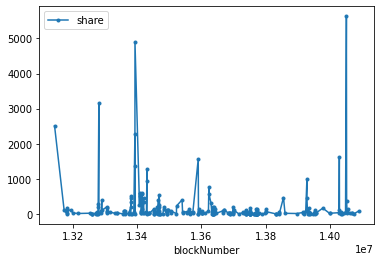

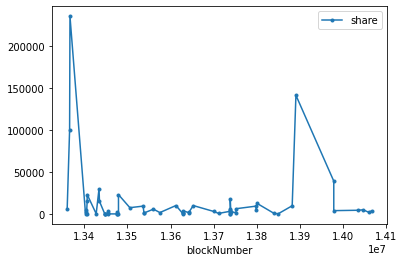

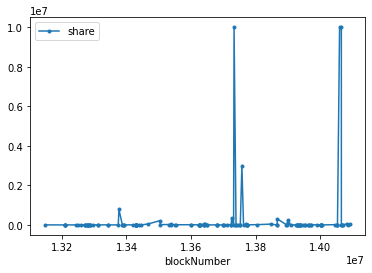

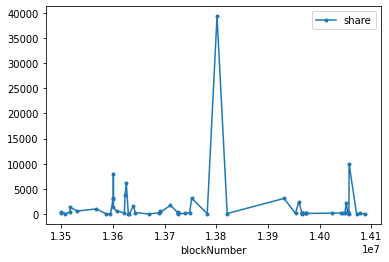

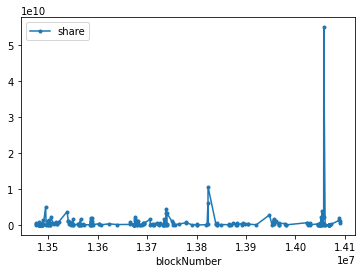

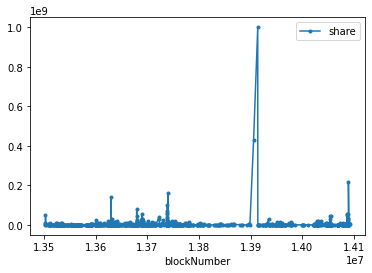

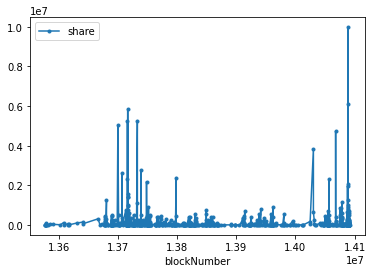

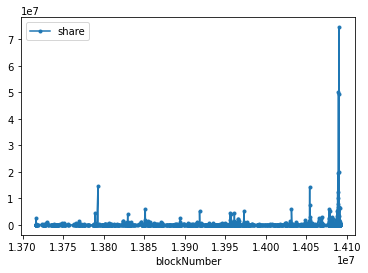

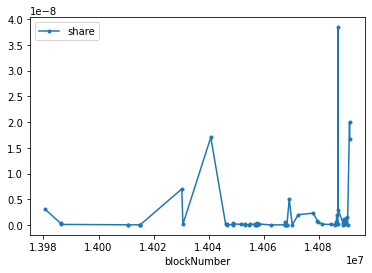

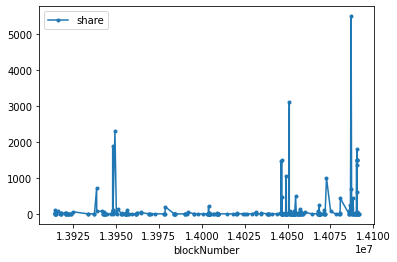

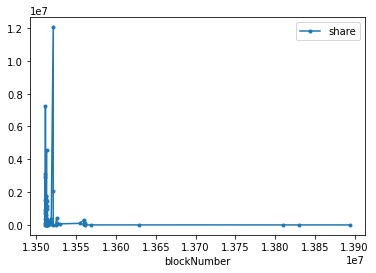

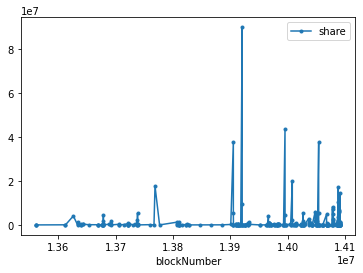

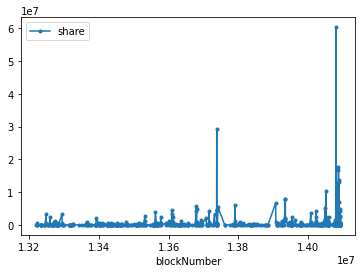

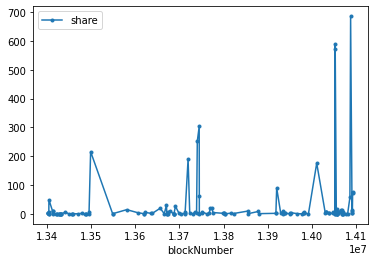

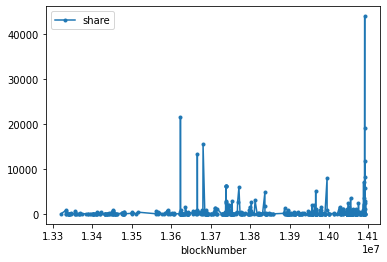

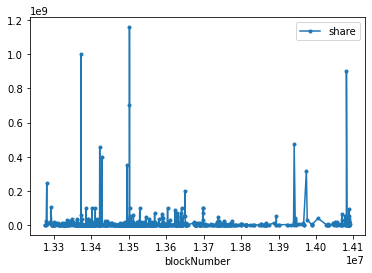

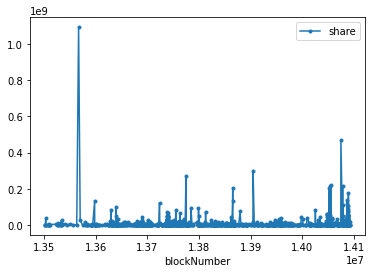

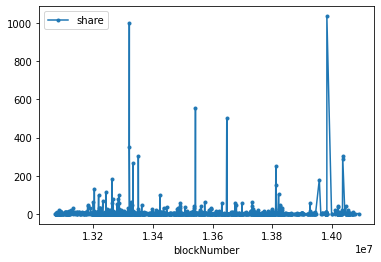

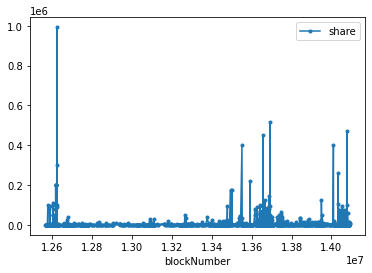

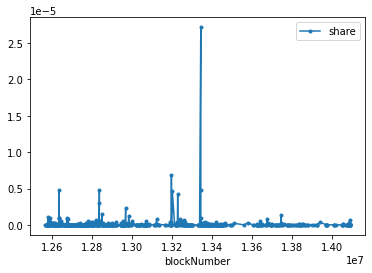

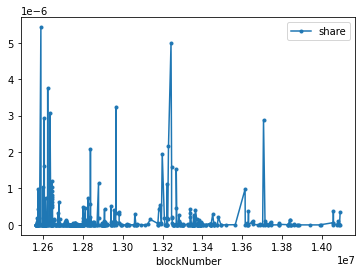

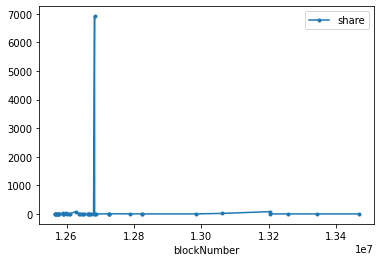

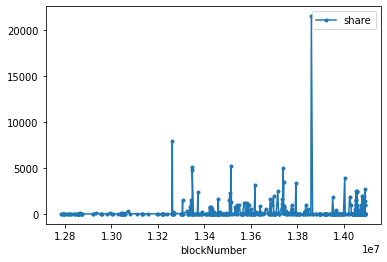

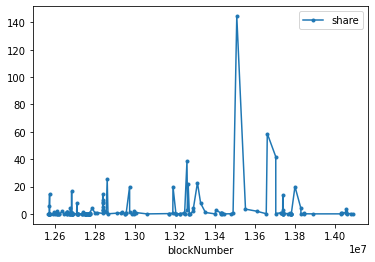

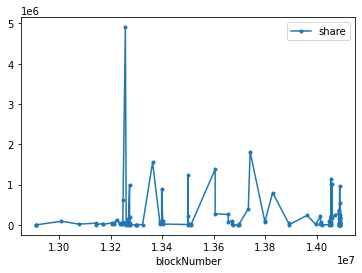

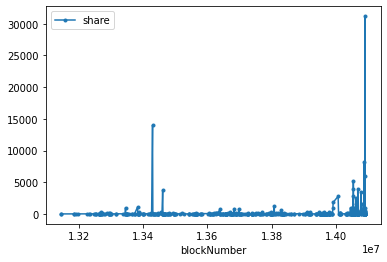

In [125]:
res = rm_col_df.groupby('token').plot("blockNumber", "share", marker=".")
plt.show()